## Sinkhorn for constrained problems 

This tutorial demonstrates how to implement and use a Sinkhorn-type algorithm for constrained optimal transport problems using the OTT-JAX library. We'll implement the algorithm described in the paper "A Sinkhorn-Type Algorithm for Constrained Optimal Transport" and show how to solve optimal transport problems with additional linear constraints beyond the usual marginal constraints.


Optimal Transport (OT) provides a principled way to compare probability distributions by finding the minimum-cost way to transform one distribution into another. The classic OT problem can be formulated as:
$$
\min_{P: P_1 = r, P^T_1 = c, P \geq 0} \langle C, P \rangle \\
$$

where
$C$ is the cost matrix,
$P$ is the transport plan,
$\mathbf{r}$ and $\mathbf{c}$ are the source and target distributions

Entropic regularization, introduced by Cuturi (2013), makes the OT problem computationally tractable through the Sinkhorn algorithm. However, in many applications, we may want to impose additional constraints on the transport plan.
In this tutorial, we'll focus on constrained OT problems of the form:
$$
\min_{P: P_1 = r, P^T_1 = c, P \geq 0} \langle C, P \rangle \\
\text{such that } D_k \cdot P \geq 0 \text{ for } k=1,\ldots,K \text{ (inequality constraints)} \\
\text{and } D_{l+K} \cdot P = 0 \text{ for } l=1,\ldots,L \text{ (equality constraints)}
$$

### Implementation: Constrained Sinkhorn Algorithm

This section implements the main loop of the algorithm, including:
- Sinkhorn-like updates for potentials (x, y)
- Newton or gradient-based updates for constraint duals (a)
- Transport plan recovery from potentials using OTT-JAX Geometry


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import Callable, Tuple, List

from ott.geometry.geometry import Geometry

SAFE_LOG_MIN = 1e-5
EXP_CLIP_MIN = -100.0
EXP_CLIP_MAX = 100.0

In [2]:
def update_xy(
    geom: Geometry,
    Dm: List[jnp.ndarray],
    x: jnp.ndarray,
    y: jnp.ndarray,
    a: jnp.ndarray,
    r: jnp.ndarray,
    c: jnp.ndarray
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    A = sum(a[m] * Dm[m] for m in range(len(Dm)))
    perturbed_cost = geom.cost_matrix - A
    shifted_geom = Geometry(cost_matrix=perturbed_cost, epsilon=geom.epsilon)

    exponent = shifted_geom.epsilon * (-perturbed_cost + x[:, None] + y[None, :]) - 1.0
    P = jnp.exp(jnp.clip(exponent, EXP_CLIP_MIN, EXP_CLIP_MAX))

    log_r = jnp.log(jnp.clip(r, a_min=SAFE_LOG_MIN))
    log_P1 = jnp.log(jnp.clip(jnp.sum(P, axis=1), a_min=SAFE_LOG_MIN))
    x_new = x + (log_r - log_P1) / shifted_geom.epsilon

    exponent = shifted_geom.epsilon * (-perturbed_cost + x_new[:, None] + y[None, :]) - 1.0
    P = jnp.exp(jnp.clip(exponent, EXP_CLIP_MIN, EXP_CLIP_MAX))

    log_c = jnp.log(jnp.clip(c, a_min=SAFE_LOG_MIN))
    log_PT1 = jnp.log(jnp.clip(jnp.sum(P, axis=0), a_min=SAFE_LOG_MIN))
    y_new = y + (log_c - log_PT1) / shifted_geom.epsilon

    P = jnp.exp(jnp.clip(
        shifted_geom.epsilon * (-perturbed_cost + x_new[:, None] + y_new[None, :]) - 1.0,
        EXP_CLIP_MIN, EXP_CLIP_MAX
    ))
    return x_new, y_new, P


In [3]:
def update_a(
    geom: Geometry,
    Dm: List[jnp.ndarray],
    x: jnp.ndarray,
    y: jnp.ndarray,
    a: jnp.ndarray,
    r: jnp.ndarray,
    target: float = None,
    max_iter: int = 10
) -> Tuple[jnp.ndarray, float]:
    t = 0.0
    eta = geom.epsilon

    for _ in range(max_iter):
        A = sum(a[m] * Dm[m] for m in range(len(Dm)))
        perturbed_cost = geom.cost_matrix - A
        exponent = eta * (-perturbed_cost + (x + t)[:, None] + y[None, :]) - 1.0
        P = jnp.exp(jnp.clip(exponent, EXP_CLIP_MIN, EXP_CLIP_MAX))

        if target is not None:
            grad = jnp.array([
                jnp.sum(P * Dm[m]) - target
                for m in range(len(Dm))
            ])
        else:
            grad = jnp.array([
                jnp.sum(P * Dm[m]) -  jnp.exp(jnp.clip(-eta * a[m] - 1.0, EXP_CLIP_MIN, EXP_CLIP_MAX))
                for m in range(len(Dm))
            ])

        H = jnp.array([
            [jnp.sum(P * Dm[m] * Dm[n]) for n in range(len(Dm))]
            for m in range(len(Dm))
        ])

        delta = jnp.linalg.solve(H + 1e-6 * jnp.eye(H.shape[0]), -grad)
        delta_max = 10.0 / eta  # scale adaptively with entropy strength
        delta = jnp.clip(delta, -delta_max, delta_max)
        a += delta
        t = jnp.log(jnp.sum(r) / jnp.clip(jnp.sum(P), a_min=SAFE_LOG_MIN)) / eta

    return a, t


def update_a_gradient(
    geom: Geometry,
    Dm: List[jnp.ndarray],
    x: jnp.ndarray,
    y: jnp.ndarray,
    a: jnp.ndarray,
    r: jnp.ndarray,
    eta: float,
    target: float = None,   # Optional
    lr: float = 1e-3
) -> Tuple[jnp.ndarray, float]:
    t = 0.0
    A = sum(a[m] * Dm[m] for m in range(len(Dm)))
    exponent = eta * (-geom.cost_matrix + (x + t)[:, None] + y[None, :] + A) - 1.0
    P = jnp.exp(jnp.clip(exponent, EXP_CLIP_MIN, EXP_CLIP_MAX))

    if target is not None:
        grad = jnp.array([
            jnp.sum(P * Dm[m]) - target
            for m in range(len(Dm))
        ])
    else:
        grad = jnp.array([
            jnp.sum(P * Dm[m]) -  jnp.exp(jnp.clip(-eta * a[m] - 1.0, EXP_CLIP_MIN, EXP_CLIP_MAX))
            for m in range(len(Dm))
        ])

    a = a - lr * grad
    t = jnp.log(jnp.clip(jnp.sum(r) / jnp.sum(P), a_min=SAFE_LOG_MIN)) / eta
    return a, t


In [4]:
def sinkhorn_constrained(
    C: jnp.ndarray,
    Dm: List[jnp.ndarray],
    r: jnp.ndarray,
    c: jnp.ndarray,
    eta: float = 50.0,  # Lower eta for stability
    max_iter: int = 100,
    tol: float = 1e-8
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    geom = Geometry(cost_matrix=C, epsilon=eta)

    n = C.shape[0]
    x = jnp.zeros(n)
    y = jnp.zeros(n)
    a = jnp.zeros(len(Dm))

    for i in range(max_iter):
        x, y, P = update_xy(geom, Dm, x, y, a, r, c)
        a, t = update_a(geom, Dm, x, y, a, r)
        x = x + t

        if i % 10 == 0:
            err = jnp.abs(jnp.sum(P, axis=1) - r).sum() + jnp.abs(jnp.sum(P, axis=0) - c).sum()
            print(f"[Iter {i}] Marginal error: {err:.4e}")
            if err < tol:
                break

    return x, y, a, P

In [5]:
def test_synthetic_example():
    n = 50
    rng = jax.random.PRNGKey(0)

    C = jax.random.uniform(rng, shape=(n, n))
    D1 = jax.random.uniform(rng, shape=(n, n))
    D2 = jax.random.uniform(rng, shape=(n, n))
    Dm = [D1, D2]

    r = jnp.ones(n) / n
    c = jnp.ones(n) / n

    x, y, a, P = sinkhorn_constrained(C, Dm, r, c, eta=5.0)

    print("Completed!")
    print("P shape:", P.shape)
    print("Constraint 1 violation:", jnp.sum(D1 * P))
    print("Constraint 2 violation:", jnp.sum(D2 * P))


In [6]:
test_synthetic_example()

[Iter 0] Marginal error: 3.1224e-02
[Iter 10] Marginal error: 3.6508e-07
[Iter 20] Marginal error: 3.5949e-07
[Iter 30] Marginal error: 3.3900e-07
[Iter 40] Marginal error: 3.5577e-07
[Iter 50] Marginal error: 3.5949e-07
[Iter 60] Marginal error: 3.3155e-07
[Iter 70] Marginal error: 3.5577e-07
[Iter 80] Marginal error: 3.4831e-07
[Iter 90] Marginal error: 3.4086e-07
Completed!
P shape: (50, 50)
Constraint 1 violation: 0.5593252
Constraint 2 violation: 0.5593252


### Experiment 1: Random Assignment with Constraints

We solve a synthetic constrained OT problem with randomly generated cost and constraint matrices. We monitor convergence of:
- Transport cost
- Marginal errors
- Constraint violations

In [7]:
import time
import matplotlib.pyplot as plt

def random_assignment_experiment(
    n: int = 200,
    num_constraints: int = 3,
    eta: float = 5.0,
    max_iter: int = 100
):
    rng = jax.random.PRNGKey(42)

    # Create synthetic cost matrix
    C = jax.random.uniform(rng, shape=(n, n))

    # Create constraint matrices Dₘ ~ Uniform[0, 1]
    Dm = [jax.random.uniform(jax.random.fold_in(rng, i), shape=(n, n)) for i in range(num_constraints)]

    # Uniform marginals
    r = jnp.ones(n) / n
    c = jnp.ones(n) / n

    # Track metrics
    cost_history = []
    marginal_err_history = []
    constraint_violation_history = []
    time_history = []

    # Initialize variables
    geom = Geometry(cost_matrix=C, epsilon=eta)
    x = jnp.zeros(n)
    y = jnp.zeros(n)
    a = jnp.zeros(num_constraints)

    for i in range(max_iter):
        t0 = time.time()
        x, y, P = update_xy(geom, Dm, x, y, a, r, c)
        a, t = update_a_gradient(geom, Dm, x, y, a, r, eta=eta)
        x = x + t
        t1 = time.time()

        # Metrics
        cost = jnp.sum(C * P)
        marginal_error = jnp.abs(jnp.sum(P, axis=1) - r).sum() + jnp.abs(jnp.sum(P, axis=0) - c).sum()
        constraint_violation = sum(
            jnp.maximum(0.0, jnp.sum(Dm[m] * P) - jnp.exp(jnp.clip(-eta * a[m] - 1.0, EXP_CLIP_MIN, EXP_CLIP_MAX)))
            for m in range(num_constraints)
        )

        cost_history.append(float(cost))
        marginal_err_history.append(float(marginal_error))
        constraint_violation_history.append(float(constraint_violation))
        time_history.append(t1 - t0)

        if i % 10 == 0:
            print(f"[Iter {i}] Cost: {cost:.4f}, Marg Err: {marginal_error:.4e}, Constraint Violation: {constraint_violation:.4e}")

    return {
        "cost": cost_history,
        "marginal_err": marginal_err_history,
        "constraint_violation": constraint_violation_history,
        "time": time_history
    }


In [8]:
def plot_random_assignment_results(results):
    iters = range(len(results["cost"]))

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(iters, results["cost"])
    plt.grid()
    plt.title("Transport Cost")
    plt.xlabel("Iteration")

    plt.subplot(1, 3, 2)
    plt.plot(iters, results["marginal_err"])
    plt.grid()
    plt.yscale("log")
    plt.title("Marginal Error")
    plt.xlabel("Iteration")

    plt.subplot(1, 3, 3)
    plt.plot(iters, results["constraint_violation"])
    plt.grid()
    plt.yscale("log")
    plt.title("Constraint Violation")
    plt.xlabel("Iteration")

    plt.tight_layout()
    plt.show()


[Iter 0] Cost: 0.0027, Marg Err: 4.2678e-01, Constraint Violation: 1.7687e-01
[Iter 10] Cost: 0.0034, Marg Err: 5.4237e-02, Constraint Violation: 1.9613e-04
[Iter 20] Cost: 0.0035, Marg Err: 1.8433e-02, Constraint Violation: 3.0816e-05
[Iter 30] Cost: 0.0035, Marg Err: 7.7657e-03, Constraint Violation: 2.3395e-05
[Iter 40] Cost: 0.0035, Marg Err: 3.7573e-03, Constraint Violation: 8.4639e-06
[Iter 50] Cost: 0.0035, Marg Err: 2.0907e-03, Constraint Violation: 2.5928e-06
[Iter 60] Cost: 0.0035, Marg Err: 1.3352e-03, Constraint Violation: 7.1526e-07
[Iter 70] Cost: 0.0035, Marg Err: 9.5968e-04, Constraint Violation: 2.9802e-07
[Iter 80] Cost: 0.0035, Marg Err: 7.3835e-04, Constraint Violation: 8.9407e-08
[Iter 90] Cost: 0.0035, Marg Err: 5.8974e-04, Constraint Violation: 0.0000e+00
[Iter 100] Cost: 0.0035, Marg Err: 4.8148e-04, Constraint Violation: 2.9802e-08
[Iter 110] Cost: 0.0035, Marg Err: 4.0033e-04, Constraint Violation: 5.9605e-08
[Iter 120] Cost: 0.0035, Marg Err: 3.3758e-04, Cons

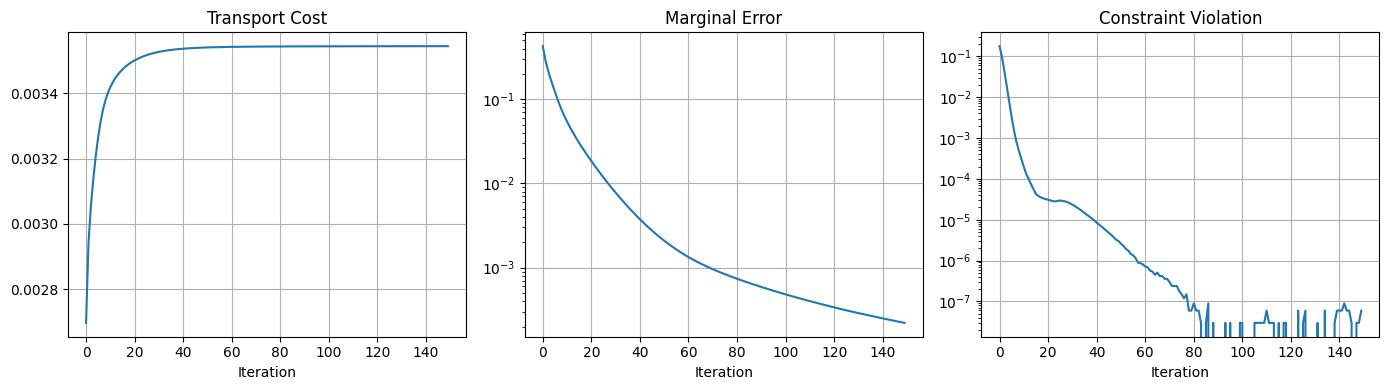

In [9]:
results = random_assignment_experiment(n=500, num_constraints=3, eta=1200.0, max_iter=150)
plot_random_assignment_results(results)

### Experiment 2: Pareto Front Trade-off

We compute Pareto fronts between two competing cost objectives $( C_1 )$ and $( C_2 )$ under entropic regularization. The constraint $( \langle C_2, P \rangle \leq t )$ is enforced for various thresholds $( t )$.

The experiment is repeated for multiple regularization values $( \eta )$, showing how the trade-off curve changes.


In [10]:
def pareto_front_experiment(
    n: int = 50,
    eta: float = 10.0,
    n_points: int = 20,
    eps: float = 1e-2
):
    # Create 2D grid of points
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(0, 1, n), jnp.linspace(0, 1, n))
    X = jnp.stack([grid_x.flatten(), grid_y.flatten()], axis=1)

    def pairwise_cost_matrix(X, p=2):
        X_norm = jnp.sum(X**2, axis=1, keepdims=True)
        dist_sq = X_norm + X_norm.T - 2 * X @ X.T
        dist_sq = jnp.maximum(dist_sq, 0.0)
        return jnp.power(dist_sq + eps, p / 2.0)

    # Define two costs: C1 (L1), C2 (L2)
    C1 = pairwise_cost_matrix(X, p=1)
    C2 = pairwise_cost_matrix(X, p=2)

    r = c = jnp.ones(n * n) / (n * n)

    # Define t-values across constraint range
    C2_unconstrained = jnp.sum(C2 * (r[:, None] * c[None, :]))
    ts = jnp.linspace(C2_unconstrained * 0.2, C2_unconstrained * 1.2, n_points)

    results = {"c1": [], "c2": [], "threshold": []}

    for t_val in ts:
        # Define D = C2 and target = t_val
        # Using a single constraint matrix
        Dm = [C2]

        # Use simple gradient update for stability
        def update_a_pareto(*args, **kwargs):
            return update_a_gradient(*args, **kwargs, eta=eta, target=t_val, lr=1e-2)

        def sinkhorn_constrained_pareto():
            geom = Geometry(cost_matrix=C1, epsilon=eta)
            x = jnp.zeros_like(r)
            y = jnp.zeros_like(c)
            a = jnp.zeros(1)

            for _ in range(100):
                x, y, P = update_xy(geom, Dm, x, y, a, r, c)
                a, t = update_a_pareto(geom, Dm, x, y, a, r)
                x += t
            return P

        P_star = sinkhorn_constrained_pareto()

        results["c1"].append(jnp.sum(C1 * P_star))
        results["c2"].append(jnp.sum(C2 * P_star))
        results["threshold"].append(t_val)

        #print(f"t={t_val:.4f} | ⟨C1,P⟩={results['c1'][-1]:.4f}, ⟨C2,P⟩={results['c2'][-1]:.4f}")

    return results

In [11]:
def plot_pareto_front(results, ax, label):
    ax.plot(results["c2"], results["c1"], marker='o', label=label)
    ax.set_xlabel("Secondary Cost ⟨C₂, P⟩")
    ax.set_ylabel("Primary Cost ⟨C₁, P⟩")
    ax.set_title("Pareto Front: Cost Tradeoff")
    ax.grid(True)

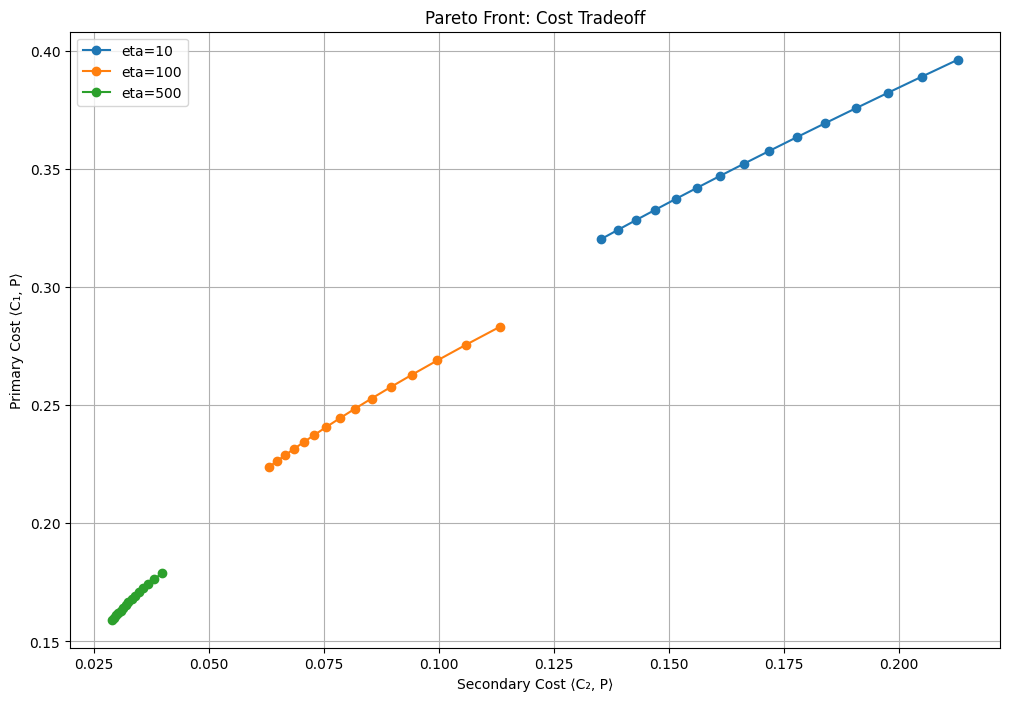

In [13]:
results_1 = pareto_front_experiment(n=10, eta=5.0, n_points=15)
results_2 = pareto_front_experiment(n=10, eta=10.0, n_points=15)
results_3 = pareto_front_experiment(n=10, eta=20.0, n_points=15)

fig, ax = plt.subplots(figsize=(12,8))
plot_pareto_front(results_1, ax, 'eta=10')
plot_pareto_front(results_2, ax, 'eta=100')
plot_pareto_front(results_3, ax, 'eta=500')
ax.legend()
plt.show()

## Conclusion

This notebook demonstrates how to implement constrained OT with entropic regularization using OTT-JAX, following a modern Sinkhorn-type approach. The method supports arbitrary linear constraints and provides smooth interpolation between objectives via a Pareto front.
